<a href="https://colab.research.google.com/github/RJKN13/Emotion-Classification-CNN-using-Keras/blob/main/emotion_classification_cnn_using_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
# !pip install keras.preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf


# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Changed import statement
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
ERROR: Operation cancelled by user


# Displaying Images

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Dataset-Emotion_Detection.zip to Dataset-Emotion_Detection.zip


In [3]:
import zipfile
import os

In [4]:
with zipfile.ZipFile('Dataset-Emotion_Detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [5]:
picture_size = 48
folder_path = "./Dataset-Emotion_Detection/images/"

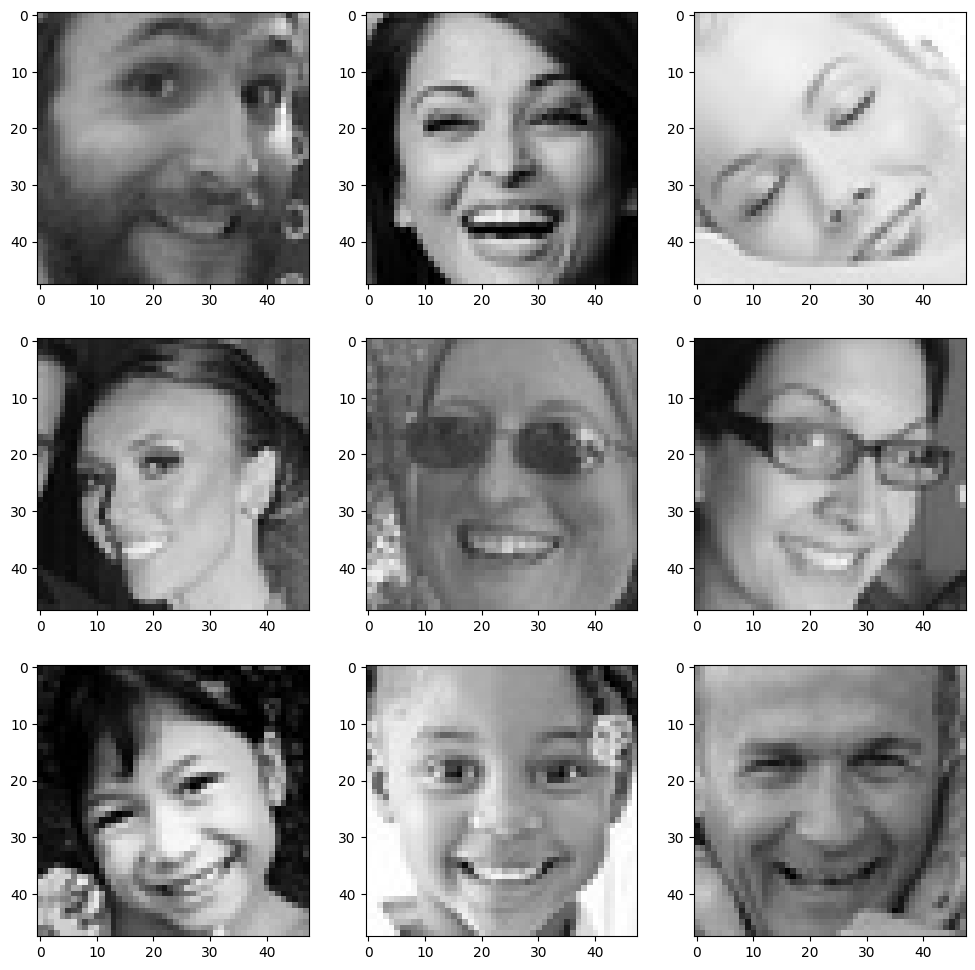

In [6]:
expression = 'happy'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

# Making Training and Validation Data

In [7]:
# Set the batch size for training and validation
batch_size = 128

# Initialize an ImageDataGenerator for the training set with data augmentation
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,# Randomly flip images horizontally
    #brightness_range=[0.2, 1.0],  # Adding brightness variation
    brightness_range=[0.1, 1.0],  # Lowering brightness to simulate low-light
    fill_mode='nearest'
)

# Initialize an ImageDataGenerator for the validation set without augmentation
datagen_val = ImageDataGenerator(rescale=1./255)

# Load the training data from the specified directory using the training ImageDataGenerator
train_set = datagen_train.flow_from_directory(
    folder_path + "train",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical', # Use categorical labels (one-hot encoded)
    shuffle=True
)

# Convert the training set to a TensorFlow Dataset object for better performance and pipeline control
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_set,
    output_signature=(
        tf.TensorSpec(shape=(None, picture_size, picture_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 7), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE) # Prefetch batches for efficient processing

# Load the validation data from the specified directory using the validation ImageDataGenerator
test_set = datagen_val.flow_from_directory(
    folder_path + "validation",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Do not shuffle the validation data
)

# Convert the validation set to a TensorFlow Dataset object for better performance and pipeline control
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_set,
    output_signature=(
        tf.TensorSpec(shape=(None, picture_size, picture_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 7), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE) # Prefetch batches for efficient processing

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model Building

In [8]:
no_of_classes = 7

# Initialize a Sequential model
model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))


# Setting learning rate
opt = Adam(learning_rate = 0.0001)

# Compile the model
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Fitting the Model with Training and Validation Data

In [9]:
# Define a checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("./model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

# Define a learning rate reduction callback to adjust the learning rate if training plateaus
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

# Combine all the callbacks into a list
callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

# Number of epochs for training
epochs = 48

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [10]:
# Train the model using the training dataset and validate it using the validation dataset
history = model.fit(
    train_dataset,
    steps_per_epoch=train_set.n // batch_size,
    epochs=epochs,
    validation_data=test_dataset,
    validation_steps=test_set.n // batch_size,
    callbacks=callbacks_list
)

Epoch 1/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.1833 - loss: 2.1313
Epoch 1: val_accuracy improved from -inf to 0.25923, saving model to ./model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 49s 144ms/step - accuracy: 0.1834 - loss: 2.1309 - val_accuracy: 0.2592 - val_loss: 1.8336 - learning_rate: 1.0000e-04
Epoch 2/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2187 - loss: 1.9558
Epoch 2: val_accuracy improved from 0.25923 to 0.26304, saving model to ./model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.2187 - loss: 1.9558 - val_accuracy: 0.2630 - val_loss: 1.8114 - learning_rate: 1.0000e-04
Epoch 3/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2257 - loss: 1.9292
Epoch 3: val_accuracy improved from 0.26304 to 0.28193, saving model to ./model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.2257 - loss: 1.9292 - val_accuracy: 0.2819 - val_loss: 1.7832 - learning_rate: 1.0000e-04
Epoch 4/48
225/225 ━━━━━━━━━━━━━━━━━━

# Plotting Accuracy & Loss

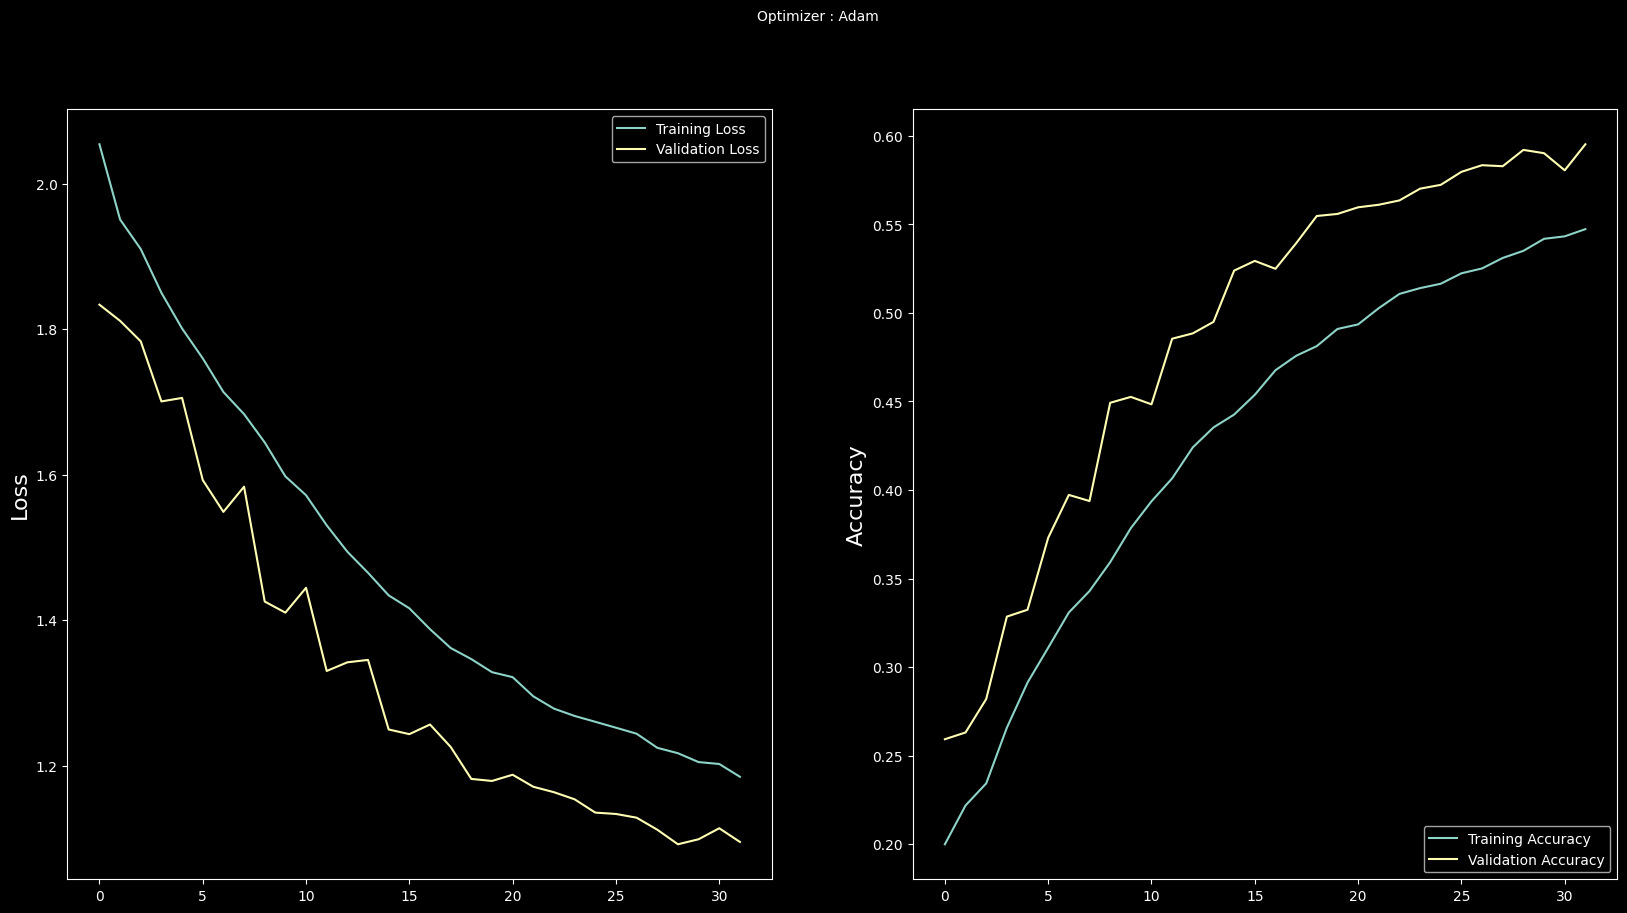

In [11]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [12]:
model.save('my_model.keras')

In [13]:
model.save('my_model.h5')